In [1]:
import ase
# import asap3
import GPy

from ase.constraints import FixAtoms, FixedLine
from ase.optimize import BFGS
from ase.visualize import view
from asap3 import EMT
# from ase.calculators.emt import EMT
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# from matplotlib.gridspec import GridSpec
# import emcee
# import corner
from scipy.stats import gamma, invgamma, t, norm, norminvgauss, mode
from scipy.optimize import minimize
import seaborn as sns
sns.set_context("paper", font_scale=1.5)
sns.set_style("darkgrid")
sns.set_palette("deep")
sns.set(font='sans-serif')
%matplotlib inline
plt.rcParams['figure.dpi'] = 140

np.random.seed(123)

In [2]:
def calculate_adatom_energy(surface, position):
    """Adds adatom to the input surface configuration at the given position
    and relaxes the ad-atoms z-cooridnate.

    Parameters
    ----------
    bare_surface
        surface configuration without adatom
    position
        position (x, y, z) at which to insert adatom in Ångström

    Returns
    -------
    tuple comprising the energy of the adatom configuration
    """
    # add adatom
    surface_with_adatom = surface.copy()
    surface_with_adatom.append(ase.Atom('Au', position))

    # attach calculator
    calc = EMT()
    surface_with_adatom.set_calculator(calc)

    # apply constraints
    constraints = []
    c = FixAtoms(indices=list(range(len(surface_with_adatom) - 1)))
    constraints.append(c)
    c = FixedLine(-1, [0, 0, 1])
    constraints.append(c)

    # relax configuration
    surface_with_adatom.set_constraint(constraints)
    dyn = BFGS(surface_with_adatom, logfile=None)
    dyn.run(fmax=0.02, steps=200)

    energy = surface_with_adatom.get_potential_energy()
    return energy

def calc_surface_energy(surface):
    # add adatom
    surface_with_adatom = surface.copy()

    # attach calculator
    calc = EMT()
    surface_with_adatom.set_calculator(calc)

    # apply constraints
    constraints = []
    c = FixAtoms(indices=list(range(len(surface_with_adatom) - 1)))
    constraints.append(c)
    c = FixedLine(-1, [0, 0, 1])
    constraints.append(c)

    # relax configuration
    surface_with_adatom.set_constraint(constraints)
    dyn = BFGS(surface_with_adatom, logfile=None)
    dyn.run(fmax=0.02, steps=200)

    energy = surface_with_adatom.get_potential_energy()
    return energy



In [3]:
from ase.io import read
surface = read('structures/surface_supercell.xyz')
E_surface = calc_surface_energy(surface)
size = 200
xmax=16.65653
ymax=2.884996
E=np.empty((size,size))

x = np.linspace(0,xmax,size)
y = np.linspace(0,ymax,size)
z = surface.get_positions()[:, 2].max() + 3



In [4]:

#To regenerate the data loaded below

run=False   #Set true to regenerate data 
save=False  #Set true to save the rerun data in file

if run:
    for xi in range(x.shape[0]):
        for yi in range(y.shape[0]):
            E[xi,yi] = calculate_adatom_energy(surface,(x[xi], y[yi],z))
        # print("xi = ",xi," done")
        sys.stdout.write("\r%d%%" % (int)(100*(xi+1)/x.shape[0]))
        sys.stdout.flush()
    if save:
        np.savetxt('heatmap.dat',E)


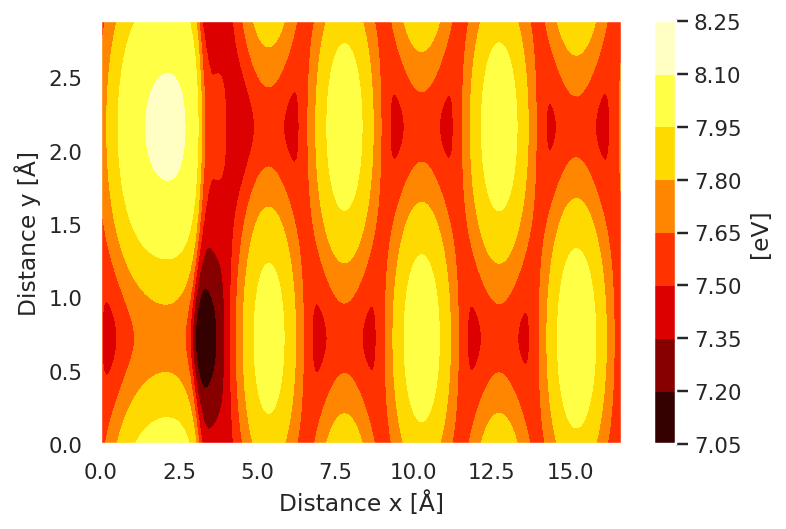

In [5]:
load=True   #Set false to use generated data
if load:
    E = np.loadtxt('heatmap.dat')

plt.contourf(x,y,E.T, cmap='hot')
cb=plt.colorbar()
cb.set_label('[eV]')
plt.xlabel('Distance x [Å]')
plt.ylabel('Distance y [Å]')
plt.savefig(fname='heatmap.pdf')



In [6]:
def min_fun(pos):
    x=pos[0]%xmax
    y=pos[1]%ymax
    return calculate_adatom_energy(surface,(x, y, z))



In [7]:
import sys

#To regenerate the data loaded below

run=False   #Set true to regenerate data 
save=False  #Set true to save the rerun data in file

if run:
    num_runs=100
    start=np.random.rand(2,num_runs)
    startx=start[0]*xmax
    starty=start[1]*ymax
    E_local = np.empty(num_runs)
    x_local = np.empty((num_runs,2))
    nfevs = np.empty(num_runs)
    result_local = []
    for i in range(num_runs):
        # minimize(min_fun, [startx[i], starty[i]])
        result_local.append(minimize(lambda Pos: calculate_adatom_energy(surface, (Pos[0],Pos[1],z)), [startx[i], starty[i]]))
        E_local[i]=result_local[i].fun
        x_local[i]=result_local[i].x
        nfevs[i]=result_local[i].nfev
        # print("i=",i)
        sys.stdout.write("\r%d%%" % (int)(100*(i+1)/num_runs))
        sys.stdout.flush()
    if save:
        np.savetxt('E_local.dat', E_local)
        np.savetxt('x_local.dat', x_local)

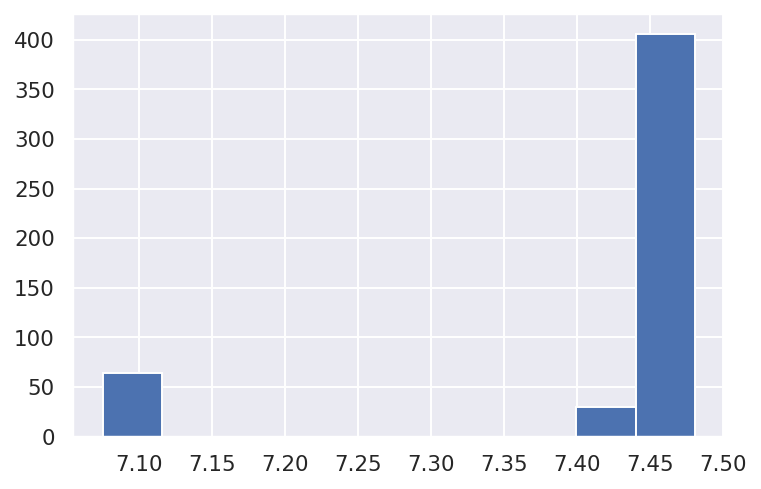

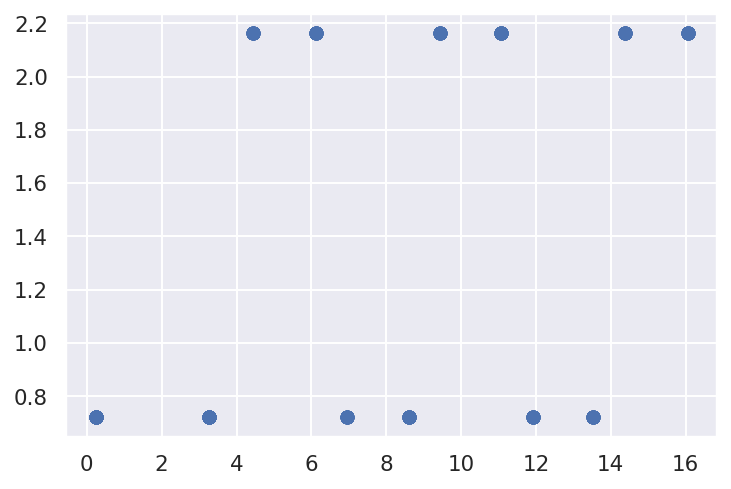

[74. 64. 30. 36. 28. 49. 31. 46. 38. 37. 31. 36.]


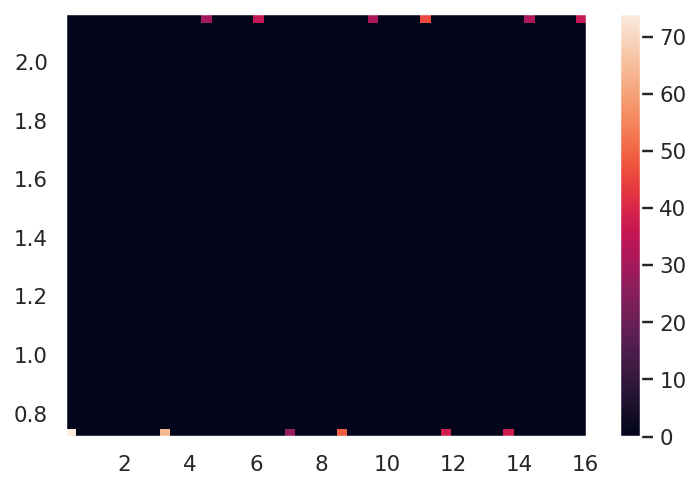

In [8]:
load=True   #Set false to use generated data
if load:
    E_local = np.loadtxt('E_local.dat')
    x_local = np.loadtxt('x_local.dat')

plt.hist(E_local)
plt.show()
plt.scatter(x_local[:,0]%xmax,x_local[:,1]%ymax)
plt.show()
a,b,c,d=plt.hist2d(x_local[:,0]%xmax,x_local[:,1]%ymax, bins=50)
print(a[a!=0])
plt.colorbar()
plt.show()

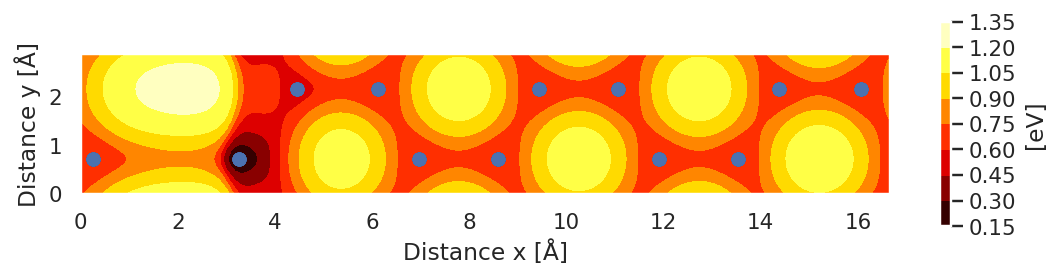

In [9]:
plt.figure(figsize=(8,2))

plt.contourf(x,y,E.T-E_surface, cmap='hot')
#plt.scatter((x_local[:,1]%ymax)*xmax/ymax,(x_local[:,0]%xmax)*ymax/xmax)
cb=plt.colorbar()

cb.set_label('[eV]')
plt.xlabel('Distance x [Å]')
plt.ylabel('Distance y [Å]')
plt.scatter(x_local[:,0],x_local[:,1])
plt.xlim((0,xmax))
plt.ylim((0,ymax))
plt.gca().set_aspect('equal', 'box')
plt.tight_layout()
plt.savefig('PES_local_min.pdf')

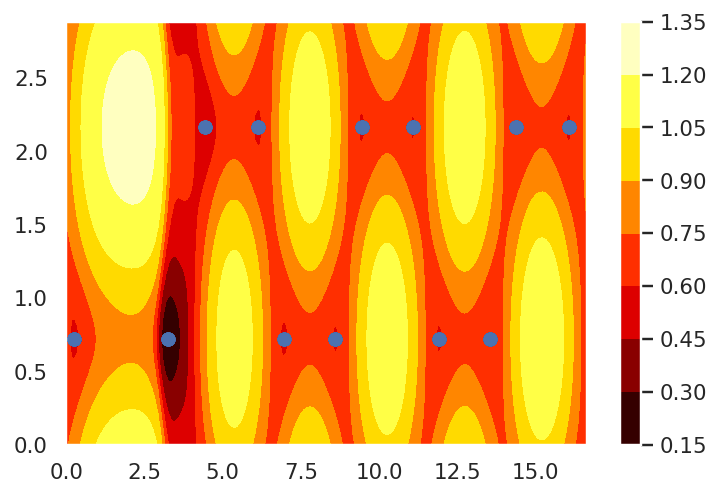

In [10]:
plt.contourf(x,y,np.transpose(E)-E_surface, cmap='hot')
plt.colorbar()
plt.scatter(x_local[:,0]%xmax,x_local[:,1]%ymax)



In [11]:

def neg_A_task3(x, model,beta):
    mu,sigma = model.predict(np.array(x,ndmin=2))
    return (mu-beta*sigma)[0]

def new_sample(model,beta,neg_A):
    # num_runs=40
    # start=np.random.rand(num_runs,2)*np.array([xmax,ymax])
    # #start=np.random.rand(2,num_runs)*np.array([xmax,ymax])
    # startx=start[0]*xmax
    # starty=start[1]*ymax
    # E_data = np.empty(num_runs)
    # x_data = np.empty((num_runs,2))
    # result_task3 = []
    # for i in range(num_runs):
    #     result_task3.append(minimize(neg_A, start[i],args=(model,beta), bounds=[(0,xmax),(0,ymax)]))
    #     E_data[i]=result_task3[i].fun
    #     x_data[i]=result_task3[i].x
    #model.optimize_restarts()
    size = 20
    startx = np.linspace(0.5,xmax-0.5,size)
    starty = np.linspace(0.1,ymax-0.1,size)
    Acq = np.empty((size,size))

    E_data =  np.empty(size*size)

    for i,x in enumerate(startx):
        for j,y in enumerate(starty):
            E_data[i*size+j] = neg_A((x,y),model,beta)
    ind = np.argmin(E_data)
    i = ind//size
    j = ind % size
    
    result_task3 = minimize(neg_A, [startx[i],starty[j]],args=(model,beta), bounds=[(0,xmax),(0,ymax)])
    x=result_task3.x

    return x, calculate_adatom_energy(surface, (x[0],x[1],z))

In [12]:
def mean_variance_2_G_alpha_beta(mean,variance):
        alpha = mean**2/variance
        beta = variance/mean
        return alpha, beta

def bayesian_opt(beta,tol,E_tol,seed):
    np.random.seed(seed)
    num_runs=5
    start=np.random.rand(num_runs,2)
    start = start*[xmax, ymax]
    # startx=start[0]*xmax
    # starty=start[1]*ymax
    E_data = np.empty((num_runs,1))
    x_data = start
    result_task3 = []
    for i in range(num_runs):
        # minimize(min_fun, [startx[i], starty[i]])
        #result_task3.append(minimize(lambda Pos: calculate_adatom_energy(surface, (Pos[0],Pos[1],z)), [startx[i], starty[i]]))
        E_data[i]=calculate_adatom_energy(surface, (start[i,0],start[i,1],z))
        #x_data[i,:]=start[i]
    
    k1 = GPy.kern.RBF(input_dim=2)#,variance=0.2**2,lengthscale=1)
    
    #k1['lengthscale'].constrain_bounded(0.1, 5)

    # a_G,b_G = mean_variance_2_G_alpha_beta(0.3,0.1**2)
    a_G,b_G = mean_variance_2_G_alpha_beta(0.5,0.2**2)
    k1['lengthscale'].set_prior(GPy.priors.Gamma(a=a_G, b=1/b_G),warning=False)


    # a_G,b_G = mean_variance_2_G_alpha_beta(1.4**2,0.3**2)
    a_G,b_G = mean_variance_2_G_alpha_beta(1.1**2,0.3**2)
    k1['variance'].set_prior(GPy.priors.Gamma(a=a_G, b=1/b_G),warning=False)


    #k1['variance'].constrain_bounded(0,1)


    k2 = GPy.kern.Bias(input_dim=2)
    kernel = k1 + k2
    num_runs3=150
    #beta = 4
    
    for i in range(num_runs3):
        model = GPy.models.GPRegression(x_data, E_data, kernel)
        model.optimize()
        
        x_new, E_new=new_sample(model,beta,neg_A_task3)
        x_data=np.append(x_data,np.array(x_new,ndmin=2),axis=0)
        E_data=np.append(E_data,np.array(E_new,ndmin=2),axis=0)
        sys.stdout.write("\r%d" % (i+1))
        sys.stdout.flush()
        
        if (x_data[-1,0]-x_data[-2,0])**2+(x_data[-1,1]-x_data[-2,1])**2<tol**2 and (E_data[-1]-E_data[-2])**2<E_tol**2:
            break
    print(" ")
    model = GPy.models.GPRegression(x_data, E_data, kernel)
    model.optimize()
    return x_data,E_data,model,i
#print(model)
#model.
#mu,sigma = model.predict(np.array((1,1),ndmin=2))

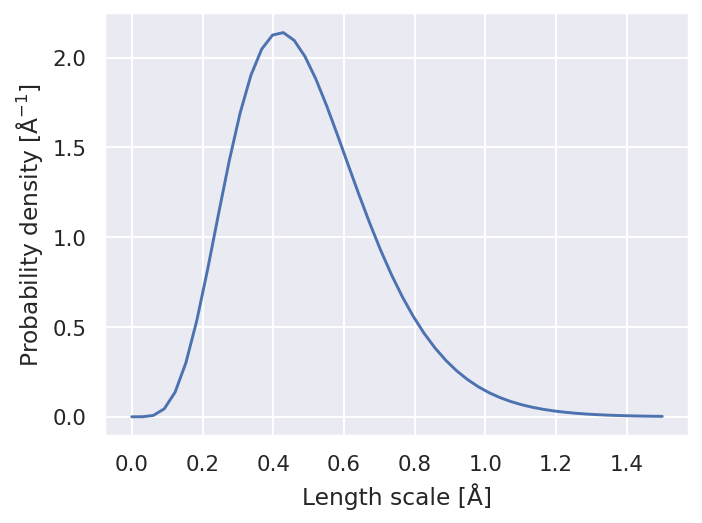

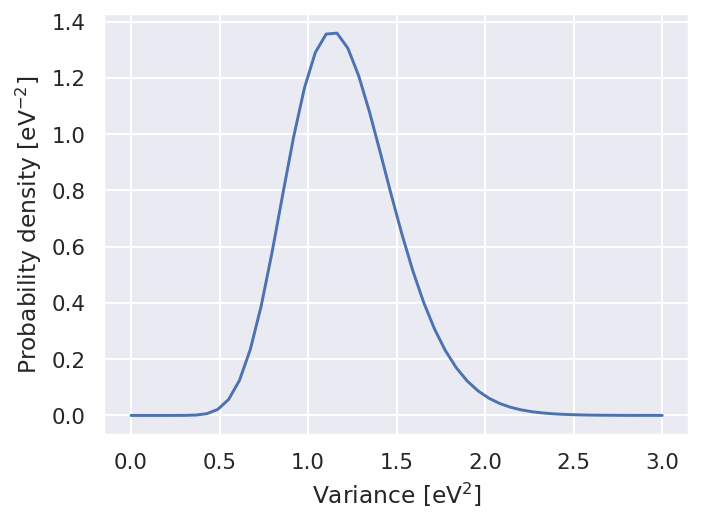

In [13]:

#Plot the priors

plt.figure(figsize=(6.4*0.8, 4.8*0.8))
a_G,b_G = mean_variance_2_G_alpha_beta(0.5,0.2**2)
xspan = np.linspace(0,1.5)
plt.plot(xspan,GPy.priors.Gamma(a=a_G, b=1/b_G).pdf(xspan))
plt.xlabel('Length scale [Å]')
plt.ylabel('Probability density [Å$^{-1}$]')
plt.tight_layout()
plt.savefig('lengthscale_prior.pdf')


plt.figure(figsize=(6.4*0.8, 4.8*0.8))
a_G,b_G = mean_variance_2_G_alpha_beta(1.1**2,0.3**2)
xspan = np.linspace(0,3)
plt.plot(xspan,GPy.priors.Gamma(a=a_G, b=1/b_G).pdf(xspan))
plt.xlabel('Variance [eV$^2$]')
plt.ylabel('Probability density [eV$^{-2}$]')
plt.tight_layout()
plt.savefig('variance_prior.pdf')

In [14]:
E_truth = 0.2022901267038888
X_truth = np.array([3.2590603 , 0.72125143])
tol = 0.05#0.01
E_tol = 0.0001#0.00005
betas = np.linspace(0,10,20)

In [15]:

#To regenerate the data loaded below

run=False   #Set true to regenerate data 

if run:
    convs = []
    Es = []
    Xs = []
    models = []
    seeds = range(20)
    # accuracy = []
    for beta in betas:
        print('\nbeta =',beta)
        # accuracy.append(0)
        for seed in seeds:  
            x_data,E_data,model,i = bayesian_opt(beta,tol,E_tol,seed)
            convs.append(i)
            Es.append(E_data)
            Xs.append(x_data)
            models.append(model)
            # if ((E_data[-1]-E_surface-E_truth)**2<(20*E_tol)**2):
            #     accuracy[-1] += 1
    accuracy = np.array([np.sum((E_task3-E_truth)[20*i:20*i+20]<0.3) for i in range(20)])            
    E_task3 = np.array([E[-1] for E in Es])-E_surface
    np.savetxt('E_task3.dat', E_task3)
    convs_task3 =[np.mean(convs[i*len(seeds):(i+1)*len(seeds)])for i in range(len(betas))]
    np.savetxt('convs_task3.dat', convs_task3)
    X_task3_0 = np.array([X[-1] for X in Xs])[:,0]
    X_task3_1 = np.array([X[-1] for X in Xs])[:,1]
    np.savetxt('X_task3_0.dat', X_task3_0)
    np.savetxt('X_task3_1.dat', X_task3_1)
    accuracy_task3 = np.array(accuracy)*100/len(seeds)
    np.savetxt('accuracy_task3.dat', accuracy_task3)

In [16]:
load=True   #Set false to use generated data
if load:
    E_task3 = np.loadtxt('./Task3_05_nosq_02_11_03/E_task3.dat')
    convs_task3 = np.loadtxt('./Task3_05_nosq_02_11_03/convs_task3.dat')
    X_task3_0 = np.loadtxt('./Task3_05_nosq_02_11_03/X_task3_0.dat')
    X_task3_1 = np.loadtxt('./Task3_05_nosq_02_11_03/X_task3_1.dat')
    accuracy_task3 = np.loadtxt('./Task3_05_nosq_02_11_03/accuracy_task3.dat')


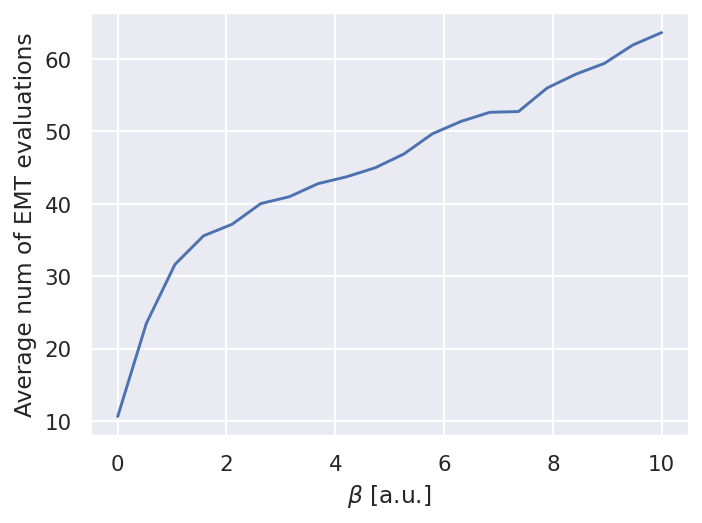

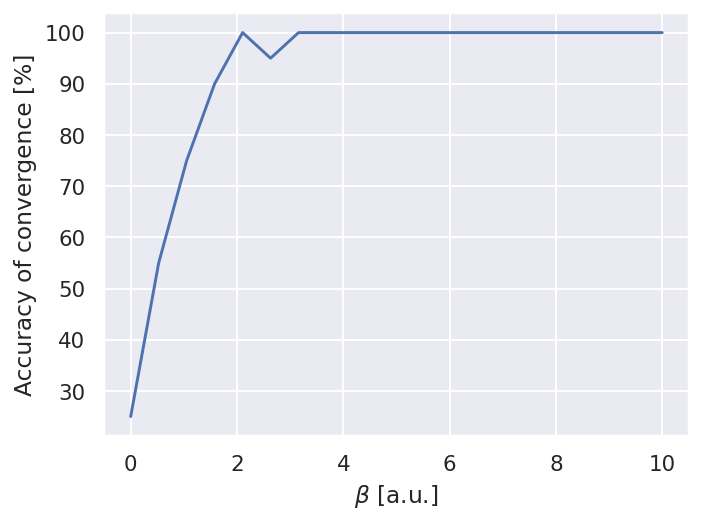

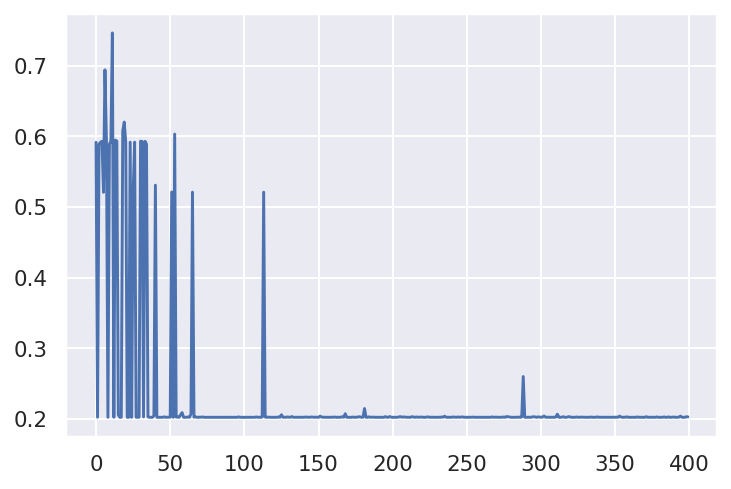

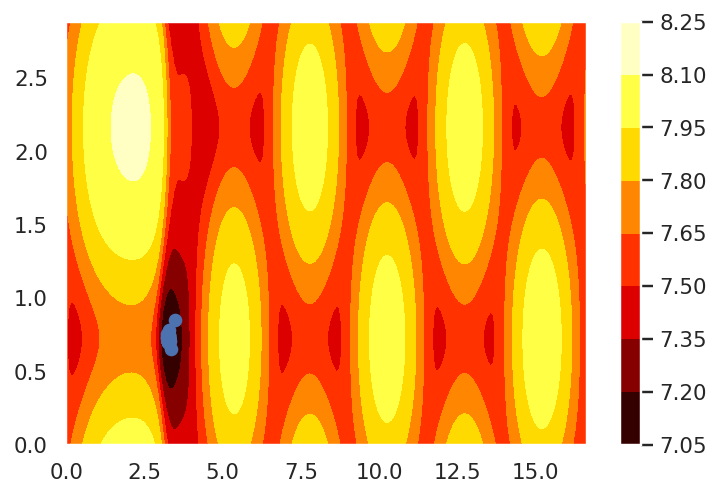

In [17]:

plt.figure(figsize=(6.4*0.8, 4.8*0.8))
plt.plot(betas,convs_task3)
plt.ylabel('Average num of EMT evaluations')
plt.xlabel(r'$\beta$ [a.u.]')
plt.tight_layout()
plt.savefig('iterations.pdf')

plt.figure(figsize=(6.4*0.8, 4.8*0.8))
plt.plot(betas,accuracy_task3)
plt.ylabel('Accuracy of convergence [%]')
plt.xlabel(r'$\beta$ [a.u.]')
plt.tight_layout()
plt.savefig('accuracy.pdf')

plt.figure()
plt.plot(E_task3)
plt.figure()
plt.contourf(x,y,E.T, cmap='hot')
plt.colorbar()
plt.scatter(X_task3_0[120:],X_task3_1[120:])

# plt.arrow(np.array(Xs)[0,0],np.array(Xs)[0,1],np.array(Xs)[1,0]-np.array(Xs)[0,0],np.array(Xs)[1,1]-np.array(Xs)[0,1])
best = np.argmin(E_task3)
# print("Best model: ", betas[best])

# plt.scatter(x_data[:,0],x_data[:,1])


In [18]:
seed = 0
beta = 4
x_data_task3,E_data_task3,model_task3,i_task3 = bayesian_opt(beta,tol,E_tol,seed)

42 


In [19]:
model = model_task3#models[best]
x_data = x_data_task3#Xs[best]
neg_A = neg_A_task3

size = 30
x_bayes = np.linspace(0,xmax,size)
y_bayes = np.linspace(0,ymax,size)
PES = np.empty((size,size))
sig = np.empty((size,size))
Acq = np.empty((size,size))

for i,xi in enumerate(x_bayes):
    for j,yi in enumerate(y_bayes):
        mu,sigma= model.predict(np.array([xi,yi],ndmin=2))
        PES[i,j]= mu
        sig[i,j] = sigma
        Acq[i,j] = -1*neg_A([xi,yi],model,beta)


Text(0.5, 1.0, '(c)')

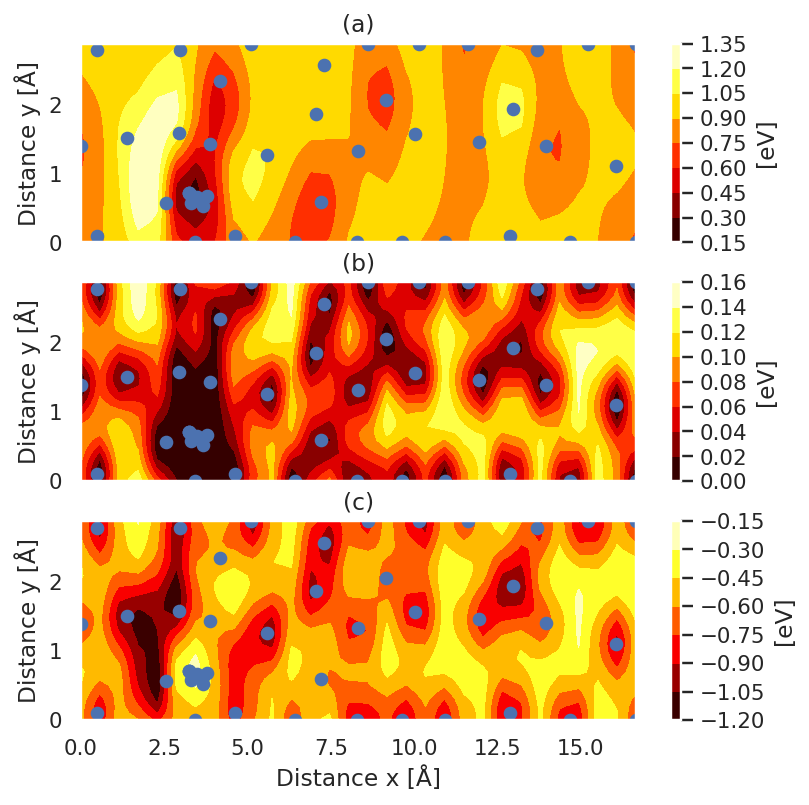

In [20]:
plt.figure(figsize=[6.4, 6.4])
ax1 = plt.subplot(311)

plt.contourf(x_bayes,y_bayes,PES.T-E_surface, cmap='hot')
cb=plt.colorbar(orientation='vertical',anchor=(0,0.5))
cb.set_label('[eV]')
plt.scatter(x_data[:,0],x_data[:,1])

plt.setp(ax1.get_xticklabels(), visible=False)
plt.ylabel('Distance y [Å]')
plt.title('(a)')
ax2 = plt.subplot(312, sharex=ax1)

# plt.contourf(x,y,E.T, cmap='hot')
# plt.colorbar(orientation='vertical',anchor=(0,0.5))
# plt.scatter(x_data[:,0],x_data[:,1])

plt.contourf(x_bayes,y_bayes,sig.T, cmap='hot')
cb=plt.colorbar()
cb.set_label('[eV]')
plt.scatter(x_data[:,0],x_data[:,1])


plt.setp(ax2.get_xticklabels(), visible=False)
plt.ylabel('Distance y [Å]')
plt.title('(b)')
ax3 = plt.subplot(313, sharex=ax1, sharey=ax1)

plt.contourf(x_bayes,y_bayes,Acq.T+E_surface, cmap='hot')
cb=plt.colorbar(orientation='vertical',anchor=(0,0.5))
cb.set_label('[eV]')
plt.scatter(x_data[:,0],x_data[:,1])
plt.ylabel('Distance y [Å]')
plt.xlabel('Distance x [Å]')
plt.title('(c)')

# plt.savefig('bayesian_GP_2D.pdf')

In [21]:
x_global = np.array([3.2590603 , 0.72125143],ndmin=2)
x_local_min = np.array((11,2.1),ndmin=2)

def neg_A_task4(x, model, beta):
    mu,sigma = model.predict(np.array(x,ndmin=2))
    return -1*(sigma)[0]

def get_RMSE(model,sparsity = 10):
    squared_error= 0
    x_len= x.shape[0]//sparsity
    y_len = y.shape[0]//sparsity
    for xi in range(x_len):
        for yi in range(y_len):
            squared_error += (model.predict(np.array((x[xi*sparsity],y[yi*sparsity]),ndmin=2))[0][0][0]-E[xi*sparsity,yi*sparsity])**2
    #     sys.stdout.write("\r%d%%" % (int)(100*(xi*sparsity+1)/x.shape[0]))
    #     sys.stdout.flush()
    # sys.stdout.write("\r%d%%" % (int)(100))
    # sys.stdout.flush()
    return np.sqrt(squared_error/(x_len*y_len))

def task4_train_model(seed,num_runs4 = 100,RMSE_sparsity=100,sparsity = 10):
    np.random.seed(seed)
    num_runs=5
    start=np.random.rand(num_runs-2,2)
    start = start*[xmax, ymax]
    start = np.array(np.append(np.append(x_global,x_local_min,axis=0),start,axis=0),ndmin=2)

    RMSE_data = np.empty((num_runs4//RMSE_sparsity,1))
    E_data = np.empty((num_runs,1))
    x_data = start
    result_task3 = []
    for i in range(num_runs):
        E_data[i]=calculate_adatom_energy(surface, (start[i,0],start[i,1],z))

    k1 = GPy.kern.RBF(input_dim=2)#, variance=1.1**2,lengthscale=0.3)
    a_G,b_G = mean_variance_2_G_alpha_beta(0.5,0.2**2)
    k1['lengthscale'].set_prior(GPy.priors.Gamma(a=a_G, b=1/b_G),warning=False)

    # a_G,b_G = mean_variance_2_G_alpha_beta(0.3**2,0.04**2)
    a_G,b_G = mean_variance_2_G_alpha_beta(1.1**2,0.3**2)
    k1['variance'].set_prior(GPy.priors.Gamma(a=a_G, b=1/b_G),warning=False)
    k2 = GPy.kern.Bias(input_dim=2)
    kernel = k1 + k2
    
    beta = 0 #dummy value
    for i in range(num_runs4):
        model = GPy.models.GPRegression(x_data, E_data, kernel)
        model.optimize()
        
        x_new, E_new=new_sample(model,beta,neg_A_task4)     
        x_data=np.append(x_data,np.array(x_new,ndmin=2),axis=0)
        E_data=np.append(E_data,np.array(E_new,ndmin=2),axis=0)

        if not((i+1)%RMSE_sparsity):
            RMSE_data[(i+1)//RMSE_sparsity-1] = get_RMSE(model,sparsity = sparsity)
        sys.stdout.write("\r%d%%" % (100*(i+1)//num_runs4))
        sys.stdout.flush()

    model = GPy.models.GPRegression(x_data, E_data, kernel)
    model.optimize()
    return x_data,E_data,model,i,RMSE_data



100%

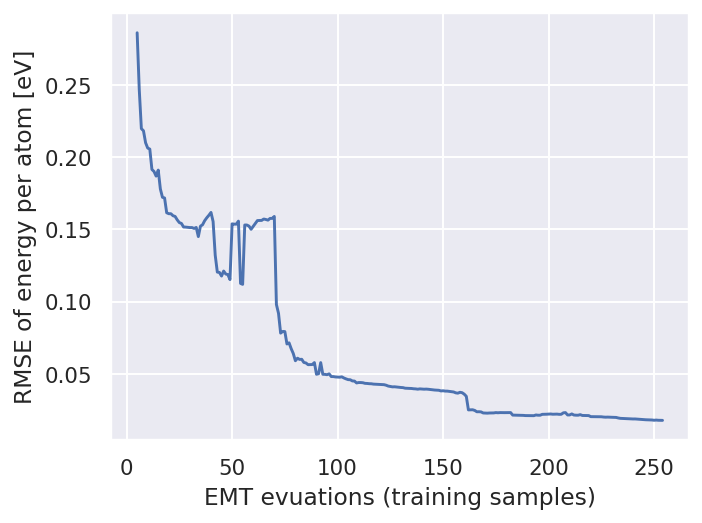

In [22]:
#Warning: Takes about 20 min to run
seed = 0
num_runs4 = 250         
RMSE_sparsity=1         
sparsity = 2
x_data_task4,E_data_task4,model_task4,i_task4,RMSE_data_task4 = task4_train_model(seed,num_runs4,RMSE_sparsity,sparsity)
plt.figure(figsize=(6.4*0.8, 4.8*0.8))
plt.plot(range(5,num_runs4+5,RMSE_sparsity),RMSE_data_task4)
plt.xlabel('EMT evuations (training samples)')
plt.ylabel('RMSE of energy per atom [eV]')
plt.tight_layout()
plt.savefig(fname='training_RMSE.pdf')


In [23]:
def X_path(Lambda):
    return (x_global+Lambda*(x_local_min-x_global)).reshape(1,2)

def E_path(Lambda):
    x_current = X_path(Lambda)[0]
    return calculate_adatom_energy(surface, (x_current[0],x_current[1],z))

def plot_1D_true(min=-0.1,max=1.1):
    mu = []
    Lambdas = np.linspace(min,max,100)
    for Lambda in Lambdas:
        mu.append(E_path(Lambda))
    mu = np.array(mu).reshape(len(mu))
    plt.plot(Lambdas,mu-E_surface, color='black',label= 'True energy')

def plot_1D(model,min=-0.1,max=1.1,label=None):
    mu = []
    sig = []
    Lambdas = np.linspace(min,max,100)
    for Lambda in Lambdas:
        mu_tmp, sig_tmp= model.predict(X_path(Lambda))
        mu.append(mu_tmp)
        sig.append(sig_tmp)
    sig = np.array(sig).reshape(len(sig))
    mu = np.array(mu).reshape(len(mu))
    plt.plot(Lambdas,mu-E_surface)
    plt.fill_between(Lambdas,mu-E_surface-sig,mu-E_surface+sig,alpha=0.5,label=label)


In [33]:
seed = 0
num_runs4 = 100
RMSE_sparsity=num_runs4
x_data_task4,E_data_task4,model_task4,i_task4,RMSE_data_task4 = task4_train_model(seed,num_runs4,RMSE_sparsity,sparsity)


100%

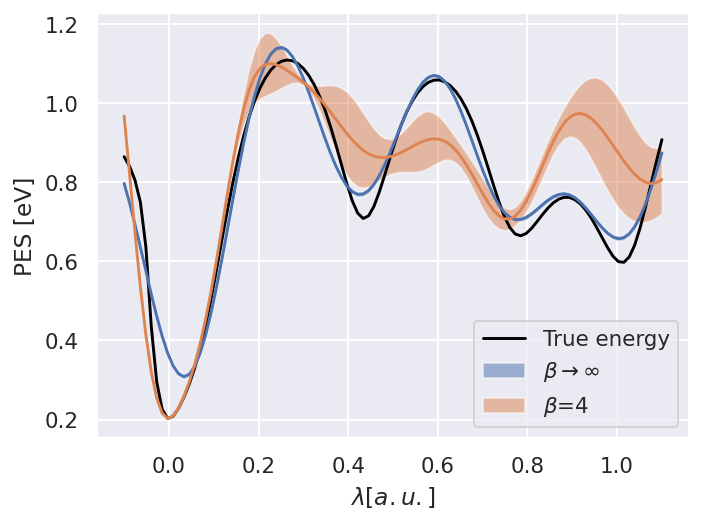

In [34]:
plt.figure(figsize=(6.4*0.8, 4.8*0.8))
plot_1D_true()
plot_1D(model_task4,label = r'$\beta \rightarrow \infty$')
plot_1D(model_task3,label = r'$\beta$=4')
plt.legend()
plt.xlabel(r'$\lambda [a.u.]$')
plt.ylabel('PES [eV]')
plt.tight_layout()
plt.savefig('1D_PES.pdf')

